In [3]:
from typing import Callable, Set, Generator, Iterable, Dict, List
import datetime
import collections
import itertools

import pymysql
import functools
from lxml import etree as et
import httplib2
from tqdm import tqdm

import helpers
import boe
import matplotlib
from matplotlib import pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [4]:
db_host = 'localhost'
db_database = 'boe'
db_user = 'root'
db_password = 'pass'

use_db_settings = lambda func, **kwargs: func(host=db_host, user=db_user, password=db_password, database=db_database, **kwargs)

# BOE entry label extraction

## Helper functions

In [5]:
def retrieve_entries(host: str, 
                     user: str, 
                     password: str, 
                     database: str, 
                     day: datetime.datetime) -> Iterable[Dict]:
    '''Retrieve entries for a specific day.'''
    
    connection = pymysql.connect(host=host,
                                 user=user,
                                 password=password,
                                 db=database)

    with connection:
        cursor = connection.cursor(pymysql.cursors.DictCursor)
        cursor.execute(f"SELECT * FROM boe_diary_entry WHERE date = '{day.isoformat()}';")
        entries = cursor.fetchall()
    
    return entries

def retrieve_sections(host: str, 
                     user: str, 
                     password: str, 
                     database: str) -> Iterable[Dict]:
    '''Retrieve a key to section name mapping.'''
    
    connection = pymysql.connect(host=host,
                                 user=user,
                                 password=password,
                                 db=database)

    with connection:
        cursor = connection.cursor(pymysql.cursors.DictCursor)
        cursor.execute(f"SELECT * FROM boe_diary_section;")
        entries = cursor.fetchall()
    
    m = {d['id']: d['name'] for d in entries}
    
    return m

def get_labels_from_tree(tree):
    tree_search = helpers.use_tree_for_search(tree)
    topics = tree_search(boe.EntryXpath.topics)
    alerts = tree_search(boe.EntryXpath.alerts)
    
    labels = helpers.pipe(topics + alerts,
        functools.partial(map, lambda x: x.xpath('text()')),
        functools.partial(map, ''.join),
        set)
    return labels

def get_tree(item):
    response = helpers.fetch_page('https://www.boe.es' + item.get('xml_url'))
    tree = helpers.tree_from_response(response)
    
    return tree

def labels_insert_queries(entry_id: str, labels: Iterable[str]) -> List[str]:
    def single_insert_query(entry_id: str, label: str) -> str:
        return f'''INSERT INTO boe_diary_entry_label (entry, name)
            VALUES ('{entry_id}', '{label}')
        '''
    
    queries = map(functools.partial(single_insert_query, entry_id), labels)
    return queries

def insert_labels(use_db_settings: Callable, entry_id: str, labels: Iterable[str]):
    if len(labels) == 0:
        return
    
    connection = use_db_settings(pymysql.connect)

    with connection:
        cursor = connection.cursor()
        
        for query in labels_insert_queries(entry_id, labels):
            cursor.execute(query)

## Execution

In [6]:
DATE = datetime.datetime(2021, 1, 26)

items = use_db_settings(retrieve_entries, day=DATE)

In [6]:
DATE = datetime.datetime(2021, 1, 26)

items = use_db_settings(retrieve_entries, day=DATE)

for item in tqdm(items):
    tree = get_tree(item)
    labels = get_labels_from_tree(tree)
    insert_labels(use_db_settings, item.get('id'), labels)

100%|██████████| 332/332 [00:43<00:00,  7.62it/s]


In [7]:
id_to_section_name = use_db_settings(retrieve_sections)
id_to_section_name

{'1': 'disposiciones generales',
 '2': 'autoridades y personal',
 '2a': 'nombramientos situaciones e incidencias',
 '2b': 'oposiciones y concursos',
 '3': 'otras secciones',
 '4': 'administración de justicia',
 '5': 'anuncios',
 '5a': 'licitaciones públicas y adjudicaciones',
 '5b': 'otros anuncios particulares',
 '5c': 'anuncios particulares',
 't': 'tribunal constitucional'}

In [56]:
prev_font_size

10.0

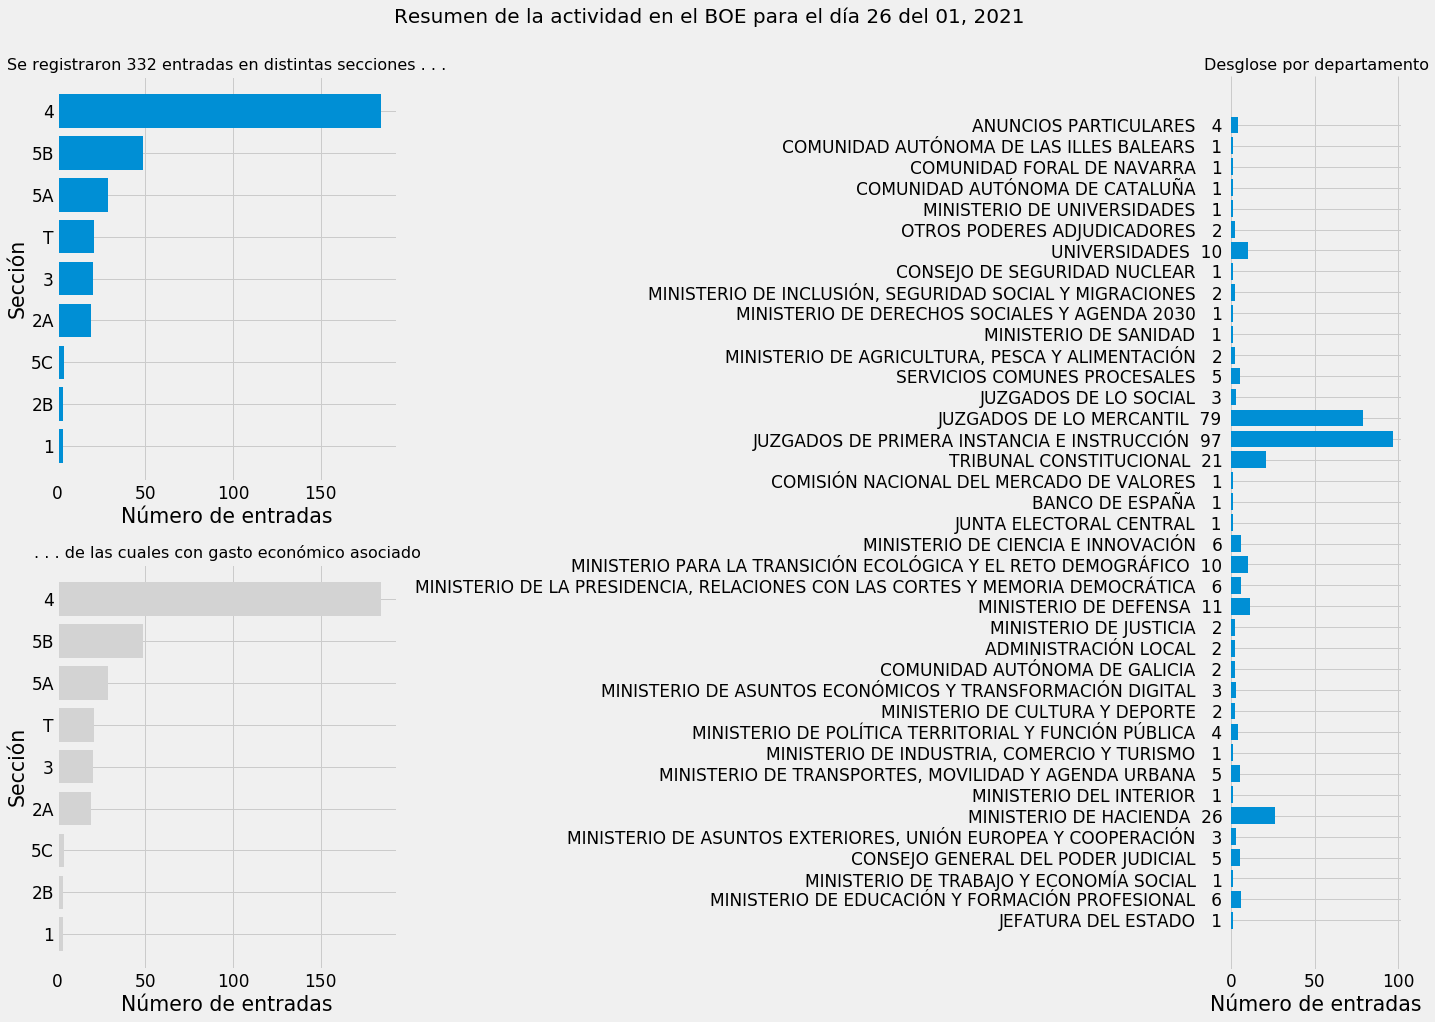

In [8]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = '17'
fig = plt.figure(figsize=(20,15))
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[2, 1])

section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
sections = sorted(section_c.items(), key=lambda x: x[1])

department_c = collections.Counter(itertools.chain((item.get('department') for item in items)))
departments = [(f'{k} {v:-3} ', v) for k, v in department_c.items()]

ax = fig.add_subplot(gs[0, 0])
ax.barh([k for k, v in sections], [v for k, v in sections])
ax.set_title(f'Se registraron {sum(section_c.values())} entradas en distintas secciones . . .', fontsize=16)
ax.set_ylabel('Sección')
ax.set_xlabel('Número de entradas')

ax = fig.add_subplot(gs[1, 0])
ax.barh([k for k, v in sections], [v for k, v in sections], color='lightgrey')
ax.set_title(f'. . . de las cuales con gasto económico asociado', fontsize=16)
ax.set_ylabel('Sección')
ax.set_xlabel('Número de entradas')

ax = fig.add_subplot(gs[:,1])
ax.barh([k for k, v in departments], [v for k, v in departments])
ax.set_title(f'Desglose por departamento', fontsize=16)
ax.set_xlabel('Número de entradas')
ax.set_frame_on(False)

fig.suptitle(f'Resumen de la actividad en el BOE para el día {DATE:%d del %m, %Y}', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

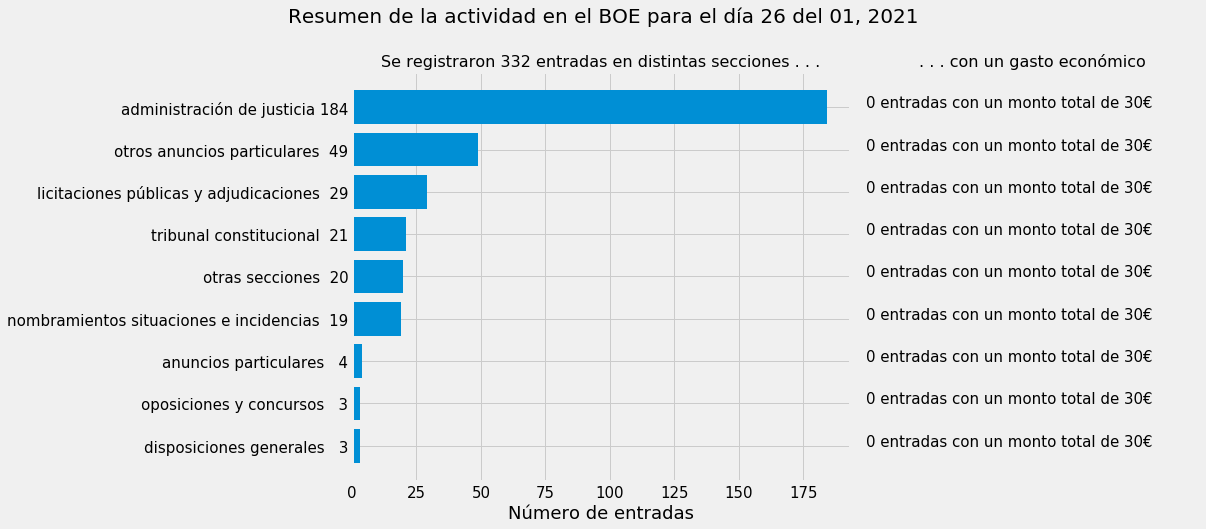

In [9]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = '15'
fig = plt.figure(figsize=(17,14))
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[3, 2])

sections = {k: 0 for k in id_to_section_name.keys()}
section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
#sections.update(section_c)
sections = section_c

sections_sorted = sorted(sections.items(), key=lambda x: x[1])
section_labels = [f'{id_to_section_name[k.lower()]} {v:-3}' for k, v in sections_sorted]

department_c = collections.Counter(itertools.chain((item.get('department') for item in items)))
departments = [(f'{k} {v:-3} ', v) for k, v in department_c.items()]

ax0 = fig.add_subplot(gs[0, 0])
ax0.barh(section_labels, [v for k, v in sections_sorted])
ax0.set_title(f'Se registraron {sum(section_c.values())} entradas en distintas secciones . . .', fontsize=16)
ax0.set_xlabel('Número de entradas')

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
#ax.barh([k for k, v in sections_sorted], [v for k, v in sections_sorted], color='lightgrey')
ax1.set_title(f'. . . con un gasto económico', fontsize=16)
ax1.axis('off')
for l, _ in enumerate(section_labels):
    ax1.text(0, l, '0 entradas con un monto total de 30€')
#ax.set_ylabel('Sección')
#ax.set_xlabel('Número de entradas')
#ax.set_

#ax = fig.add_subplot(gs[:,1])
#ax.barh([k for k, v in departments], [v for k, v in departments])
#ax.set_title(f'Desglose por departamento', fontsize=16)
#ax.set_xlabel('Número de entradas')
#ax.set_frame_on(False)

fig.suptitle(f'Resumen de la actividad en el BOE para el día {DATE:%d del %m, %Y}', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

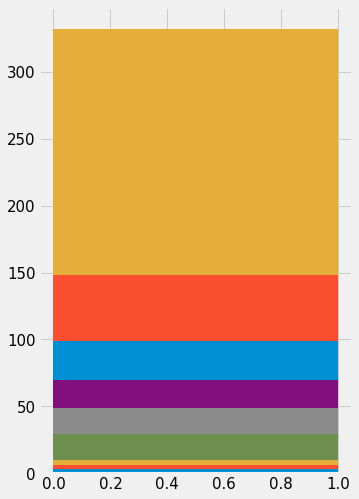

In [11]:
fig, ax = plt.subplots(figsize=(5,8))
ax.stackplot([0,1], list([d[1], d[1]] for d in sections_sorted))
None

In [147]:
fig.savefig('summary_26_01_2021_3.png', bbox_inches="tight")

In [12]:
title_c = collections.Counter(itertools.chain(*(item.get('title').split() for item in items)))

In [12]:
section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
section_c

Counter({'1': 3,
         '2A': 19,
         '2B': 3,
         '3': 20,
         'T': 21,
         '4': 184,
         '5A': 29,
         '5B': 49,
         '5C': 4})

In [48]:
epigraph_c = collections.Counter(itertools.chain((item.get('epigraph') for item in items)))
epigraph_c

Counter({'Medidas urgentes': 1,
         'Organización': 2,
         'Nombramientos': 8,
         'Destinos': 9,
         'Personal directivo': 1,
         'Ceses': 1,
         'Letrados al servicio del Tribunal Supremo': 1,
         'Cuerpo de funcionarios docentes': 1,
         'Personal funcionario y laboral': 1,
         'Agencia Española de Cooperación Internacional para el Desarrollo. Cuentas anuales': 1,
         'Convenios': 11,
         'Comunidad Foral de Navarra. Convenio': 1,
         'Delegación de competencias': 1,
         'Sector eléctrico': 1,
         'Deuda del Estado': 1,
         'Cargos representativos locales': 1,
         'Mercado de divisas': 1,
         'Agencias de valores': 1,
         'Competencias profesionales': 1,
         'Sentencias': 19,
         'Autos': 2,
         '': 266})

In [50]:
department_c = collections.Counter(itertools.chain((item.get('department') for item in items)))
department_c

Counter({'JEFATURA DEL ESTADO': 1,
         'MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL': 6,
         'MINISTERIO DE TRABAJO Y ECONOMÍA SOCIAL': 1,
         'CONSEJO GENERAL DEL PODER JUDICIAL': 5,
         'MINISTERIO DE ASUNTOS EXTERIORES, UNIÓN EUROPEA Y COOPERACIÓN': 3,
         'MINISTERIO DE HACIENDA': 26,
         'MINISTERIO DEL INTERIOR': 1,
         'MINISTERIO DE TRANSPORTES, MOVILIDAD Y AGENDA URBANA': 5,
         'MINISTERIO DE INDUSTRIA, COMERCIO Y TURISMO': 1,
         'MINISTERIO DE POLÍTICA TERRITORIAL Y FUNCIÓN PÚBLICA': 4,
         'MINISTERIO DE CULTURA Y DEPORTE': 2,
         'MINISTERIO DE ASUNTOS ECONÓMICOS Y TRANSFORMACIÓN DIGITAL': 3,
         'COMUNIDAD AUTÓNOMA DE GALICIA': 2,
         'ADMINISTRACIÓN LOCAL': 2,
         'MINISTERIO DE JUSTICIA': 2,
         'MINISTERIO DE DEFENSA': 11,
         'MINISTERIO DE LA PRESIDENCIA, RELACIONES CON LAS CORTES Y MEMORIA DEMOCRÁTICA': 6,
         'MINISTERIO PARA LA TRANSICIÓN ECOLÓGICA Y EL RETO DEMOGRÁFICO': 10,

In [51]:
sum(department_c.values())

332

In [37]:
max(title_c.values())

1108

In [39]:
[word for word, count in title_c.items() if count == 6]

['enero,',
 'Junta',
 'Comisión',
 'Acuerdo',
 'nombra',
 'Seguridad',
 'Consejería',
 'Artes',
 '20',
 'Estado',
 'ejercicio',
 'Social',
 'Segunda.',
 'libertad',
 'Lorca',
 'efectiva:',
 '40/2020',
 '[inadecuada',
 'utilización',
 'dirección',
 'electrónica',
 'habilitada',
 'cauce',
 'comunicación',
 '(SSTC',
 '6/2019',
 '47/2019)',
 'oposición',
 'confusión',
 'jurídicas',
 'relacionarse',
 'comunicaciones',
 'electrónicas',
 'civiles].',
 'Investigaciones',
 'Científicas,',
 'M.P.',
 'Facultad',
 'Costas']

In [40]:
items[0]

{'id': 'BOE-A-2021-1064',
 'date': datetime.date(2021, 1, 26),
 'title': 'Corrección de errores del Real Decreto-ley 36/2020, de 30 de diciembre, por el que se aprueban medidas urgentes para la modernización de la Administración Pública y para la ejecución del Plan de Recuperación, Transformación y Resiliencia.',
 'section': '1',
 'department': 'JEFATURA DEL ESTADO',
 'epigraph': 'Medidas urgentes',
 'pdf_url': '/boe/dias/2021/01/26/pdfs/BOE-A-2021-1064.pdf',
 'xml_url': '/diario_boe/xml.php?id=BOE-A-2021-1064',
 'htm_url': '/diario_boe/txt.php?id=BOE-A-2021-1064',
 'has_economic_impact': None}

In [71]:
sections

Counter({'1': 3,
         '2A': 19,
         '2B': 3,
         '3': 20,
         'T': 21,
         '4': 184,
         '5A': 29,
         '5B': 49,
         '5C': 4})

[('JEFATURA DEL ESTADO', '1'),
 ('MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL', '1'),
 ('MINISTERIO DE TRABAJO Y ECONOMÍA SOCIAL', '1'),
 ('CONSEJO GENERAL DEL PODER JUDICIAL', '2A'),
 ('CONSEJO GENERAL DEL PODER JUDICIAL', '2A'),
 ('CONSEJO GENERAL DEL PODER JUDICIAL', '2A'),
 ('CONSEJO GENERAL DEL PODER JUDICIAL', '2A'),
 ('MINISTERIO DE ASUNTOS EXTERIORES, UNIÓN EUROPEA Y COOPERACIÓN', '2A'),
 ('MINISTERIO DE HACIENDA', '2A'),
 ('MINISTERIO DE HACIENDA', '2A'),
 ('MINISTERIO DEL INTERIOR', '2A'),
 ('MINISTERIO DE TRANSPORTES, MOVILIDAD Y AGENDA URBANA', '2A'),
 ('MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL', '2A'),
 ('MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL', '2A'),
 ('MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL', '2A'),
 ('MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL', '2A'),
 ('MINISTERIO DE INDUSTRIA, COMERCIO Y TURISMO', '2A'),
 ('MINISTERIO DE POLÍTICA TERRITORIAL Y FUNCIÓN PÚBLICA', '2A'),
 ('MINISTERIO DE POLÍTICA TERRITORIAL Y FUNCIÓN PÚBLICA', '2A'),


In [23]:
for item in items:
    tree = get_tree(item)
    labels = get_labels_from_tree(tree)
    print(item.get('title'))
    print(labels)

Corrección de errores del Real Decreto-ley 36/2020, de 30 de diciembre, por el que se aprueban medidas urgentes para la modernización de la Administración Pública y para la ejecución del Plan de Recuperación, Transformación y Resiliencia.
{'Administración electrónica', 'Política económica', 'Epidemias', 'Industria', 'Medio ambiente', 'Unión Europea', 'Ayudas', 'Obras y construcciones', 'Administraciones Públicas', 'Contrato de concesión de obras públicas', 'Instituto de Comercio Exterior', 'Derecho Administrativo', 'Autorizaciones', 'Organización de la Administración', 'Evaluación de impacto ambiental', 'Procedimiento administrativo', 'Agencias estatales', 'Tecnología e investigación', 'Presupuestos Generales del Estado', 'Organización de la Administración del Estado'}
Orden EFP/38/2021, de 21 de enero, por la que se modifica la Orden EFP/1418/2018, de 27 de diciembre, por la que se crea la Junta de Contratación y se constituye la Mesa de Contratación del Ministerio de Educación y Form

Resolución de 14 de enero de 2021, de la Secretaría de Estado de Justicia, por la que se publica el Convenio con la Fundación Universitat Pompeu Fabra, para la realización de prácticas en el Departamento de Barcelona del Instituto Nacional de Toxicología y Ciencias Forenses.
set()
Resolución 420/38660/2020, de 17 de noviembre, de la Secretaría General Técnica, por la que se publica el Convenio con la Real Hermandad de Veteranos de las Fuerzas Armadas y de la Guardia Civil, para la realización de actividades de voluntariado en el Hospital Central de la Defensa Gómez Ulla.
set()
Orden EFP/43/2021, de 21 de enero, sobre fijación de límites para la administración de determinados créditos para gastos y de delegación de competencias.
{'Dirección General de Planificación y Gestión Educativa', 'Secretarías generales técnicas ministeriales', 'Dirección General de Evaluación y Cooperación Territorial', 'Centros de enseñanza españoles en el extranjero', 'Direcciones provinciales ministeriales', '

Sala Segunda. Sentencia 182/2020, de 14 de diciembre de 2020. Recurso de amparo 1192-2019. Promovido por don Sergio Linacero Fajardo en relación con el decreto dictado por la letrada de la administración de justicia de un juzgado de lo penal de Valencia en procedimiento de ejecutoria. Vulneración del derecho a la tutela judicial efectiva (acceso a la jurisdicción): resolución que, en aplicación del precepto anulado por la STC 151/2020, de 22 de octubre, impide la revisión judicial de decisiones adoptadas por la letrada de la administración de justicia.
set()
Sala Primera. Sentencia 183/2020, de 14 de diciembre de 2020. Recurso de amparo 3096-2019. Promovido por Penrei Inversiones, S.L., respecto de las resoluciones dictadas por un juzgado de primera instancia e instrucción de Lorca en procedimiento de ejecución hipotecaria. Vulneración del derecho a la tutela judicial efectiva: STC 40/2020 [inadecuada utilización de la dirección electrónica habilitada como cauce de comunicación del pri

Pleno. Sentencia 193/2020, de 17 de diciembre de 2020. Recurso de amparo 5198-2019. Promovido por don Jordi Turull i Negre respecto de los acuerdos de la mesa del Congreso de los Diputados declarando su suspensión como diputado. Supuesta vulneración de los derechos al ejercicio del cargo público representativo y a la presunción de inocencia: STC 97/2020 [resoluciones parlamentarias que aplican la previsión legal de suspensión automática del ejercicio del cargo parlamentario (STC 71/1994)].
set()
Pleno. Sentencia 194/2020, de 17 de diciembre de 2020. Recurso de amparo 5199-2019. Promovido por don Josep Rull i Andreu respecto de los acuerdos de la mesa del Congreso de los Diputados declarando su suspensión como diputado. Supuesta vulneración de los derechos al ejercicio del cargo público representativo y a la presunción de inocencia: STC 97/2020 [resoluciones parlamentarias que aplican la previsión legal de suspensión automática del ejercicio del cargo parlamentario (STC 71/1994)].
set()

Anuncio de la Confederación Hidrográfica del Guadalquivir de desistimiento del procedimiento de adjudicación del "contrato de obra de renovación integral de elementos de valvulería, electromecánicos y otros de la presa del Quéntar (Granada). GR(DT)-5997".
set()
Anuncio de licitación de: Gerencia de Atención Sanitaria de Melilla - Instituto Nacional de Gestión Sanitaria. Objeto: Servicio de transporte sanitario en Melilla de enfermos a los que el INGESA tenga el deber legal o convencional de trasladar en ambulancia. Expediente: P.A. 2020-12-GME.
set()
Anuncio de formalización de contratos de: Subdirección General de Análisis Presupuestario y Gestión Financiera del Instituto de Mayores y Servicios Sociales. Objeto: Servicio de reserva y ocupación de plazas residenciales y de centro de día para personas dependientes con discapacidad intelectual en Ceuta. Expediente: 317/2020.
set()
Anuncio de licitación de: Presidencia de la Agencia Estatal Consejo Superior de Investigaciones Científicas,

Anuncio del Servicio Provincial de Costas en Lugo referente a la Información pública de la solicitud de autorización para impartir cursos de surf en la playa de Lóngara, T.M. Barreirros (Lugo).
set()
Anuncio de la Demarcación de Costas en Cantabria sobre solicitud de autorización de servicios de temporada en playas del término municipal de Alfoz de Lloredo. Peticionario: Ayuntamiento de Alfoz de Lloredo. Expediente AUT01/21/39/0006.
set()
Anuncio del Servicio Provincial de Costas en Lugo referente a la Información pública de la solicitud de autorización para impartir cursos de surf en la playa de A Rapadoira, T.M. Foz (Lugo).
set()
Anuncio del Servicio Provincial de Costas en Lugo referente a la Información pública de la solicitud de autorización para instalación de terraza en Plaza Calvo Sotelo y Bustelo, 2 – Rinlo, T.M. Ribadeo (Lugo).
set()
Anuncio de la Demarcación de Costas en Asturias sobre inicio de expediente de autorización de ocupación del dominio público marítimo-terrestre d

#### using plotly

In [13]:
init_notebook_mode(connected=True)

data preparation

plotly will require both nodes and links to be integers, so they need to be indexed

In [76]:
def get_source_and_targets(items, id_to_section_name):
    sections = collections.Counter(itertools.chain((item.get('section') for item in items)))
    sections_sorted = sorted(sections.items(), key=lambda x: -x[1])
    sorted_section_names = [id_to_section_name[x.lower()] for x,y in sections_sorted]
    department_to_section = dict([(d['department'], id_to_section_name[d['section'].lower()]) for d in items])
    sorted_links = sorted(department_to_section.items(), key=lambda d: sorted_section_names.index(d[1]))
    
    name_2_id = {id_to_section_name[d.lower()]:i for i, d in enumerate(x[0] for x in sections_sorted)}
    name_2_id.update({d:len(sections_sorted)+i for i, d in enumerate(set(department_to_section.keys()))})
    
    return [(name_2_id[y], name_2_id[x]) for x,y in sorted_links], {v: k for k,v in name_2_id.items()}

section_department_pairs, id_2_name = get_source_and_targets(items, id_to_section_name)

In [39]:
{d[0] for d in section_department_pairs}

{'administración de justicia',
 'anuncios particulares',
 'disposiciones generales',
 'licitaciones públicas y adjudicaciones',
 'nombramientos situaciones e incidencias',
 'oposiciones y concursos',
 'otras secciones',
 'otros anuncios particulares',
 'tribunal constitucional'}

In [75]:
section_name_to_id

{'disposiciones generales': '1',
 'autoridades y personal': '2',
 'nombramientos situaciones e incidencias': '2a',
 'oposiciones y concursos': '2b',
 'otras secciones': '3',
 'administración de justicia': '4',
 'anuncios': '5',
 'licitaciones públicas y adjudicaciones': '5a',
 'otros anuncios particulares': '5b',
 'anuncios particulares': '5c',
 'tribunal constitucional': 't'}

In [84]:
section_c

Counter({'1': 3,
         '2A': 19,
         '2B': 3,
         '3': 20,
         'T': 21,
         '4': 184,
         '5A': 29,
         '5B': 49,
         '5C': 4})

In [85]:
section_name_to_id

{'disposiciones generales': '1',
 'autoridades y personal': '2',
 'nombramientos situaciones e incidencias': '2a',
 'oposiciones y concursos': '2b',
 'otras secciones': '3',
 'administración de justicia': '4',
 'anuncios': '5',
 'licitaciones públicas y adjudicaciones': '5a',
 'otros anuncios particulares': '5b',
 'anuncios particulares': '5c',
 'tribunal constitucional': 't'}

In [86]:
labels = [y for x, y in sorted(id_2_name.items(), key=lambda x: x[0])]
section_name_to_id = {v: k for k, v in id_to_section_name.items()}
for i in range(len(labels)):
    if labels[i] in department_c:
        labels[i] = f'{labels[i]} ({department_c[labels[i]]})'
    else:
        labels[i] = f'{labels[i]} ({section_c[section_name_to_id[labels[i]].upper()]})'
    
labels

['administración de justicia (184)',
 'otros anuncios particulares (49)',
 'licitaciones públicas y adjudicaciones (29)',
 'tribunal constitucional (21)',
 'otras secciones (20)',
 'nombramientos situaciones e incidencias (19)',
 'anuncios particulares (4)',
 'disposiciones generales (3)',
 'oposiciones y concursos (3)',
 'MINISTERIO DE JUSTICIA (2)',
 'UNIVERSIDADES (10)',
 'MINISTERIO DE DERECHOS SOCIALES Y AGENDA 2030 (1)',
 'MINISTERIO DE UNIVERSIDADES (1)',
 'COMUNIDAD FORAL DE NAVARRA (1)',
 'JUZGADOS DE LO SOCIAL (3)',
 'MINISTERIO DE CULTURA Y DEPORTE (2)',
 'CONSEJO DE SEGURIDAD NUCLEAR (1)',
 'MINISTERIO DE INCLUSIÓN, SEGURIDAD SOCIAL Y MIGRACIONES (2)',
 'MINISTERIO DE ASUNTOS EXTERIORES, UNIÓN EUROPEA Y COOPERACIÓN (3)',
 'MINISTERIO DE HACIENDA (26)',
 'COMUNIDAD AUTÓNOMA DE GALICIA (2)',
 'MINISTERIO DE CIENCIA E INNOVACIÓN (6)',
 'BANCO DE ESPAÑA (1)',
 'MINISTERIO DE AGRICULTURA, PESCA Y ALIMENTACIÓN (2)',
 'MINISTERIO DE EDUCACIÓN Y FORMACIÓN PROFESIONAL (6)',
 'JUNTA 

In [87]:
import plotly.graph_objects as go # Import the graphical object

fig = go.Figure( 
    data=[go.Sankey( # The plot we are interest
        # This part is for the node information
        node = dict( 
            label = labels
        ),
        # This part is for the link information
        link = dict(
            source = [x for x,y in section_department_pairs],
            target = [y for x,y in section_department_pairs],
            value = [department_c[id_2_name[y]] for x,y in section_department_pairs]
        ))])

# With this save the plots 
#plot(fig,
# image_filename='sankey_plot_1', 
#  image='png', 
#   image_width=1000, 
#    image_height=600
#)
# And shows the plot
fig.update_layout(
autosize=False,
width=1000,
height=1400,)
fig.show()